<a href="https://colab.research.google.com/github/MonikSense/Diabetes/blob/main/diabetesfinalv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (100000, 9)
Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

✅ Target column detected as: diabetes
✅ Data Split: Train=60000, Validation=20000, Test=20000

🔹 Training Logistic Regres

/tmp/ipython-input-1189447945.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_df.index, y=acc_df['Accuracy'], palette='viridis')


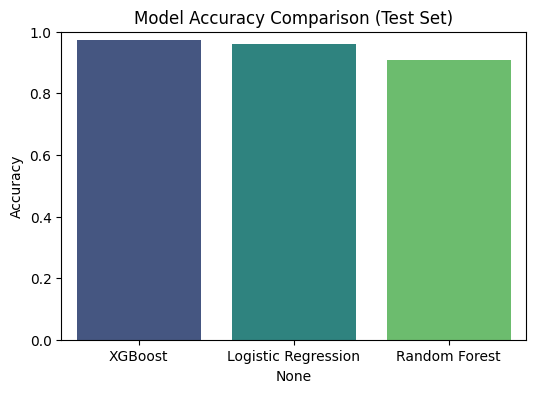

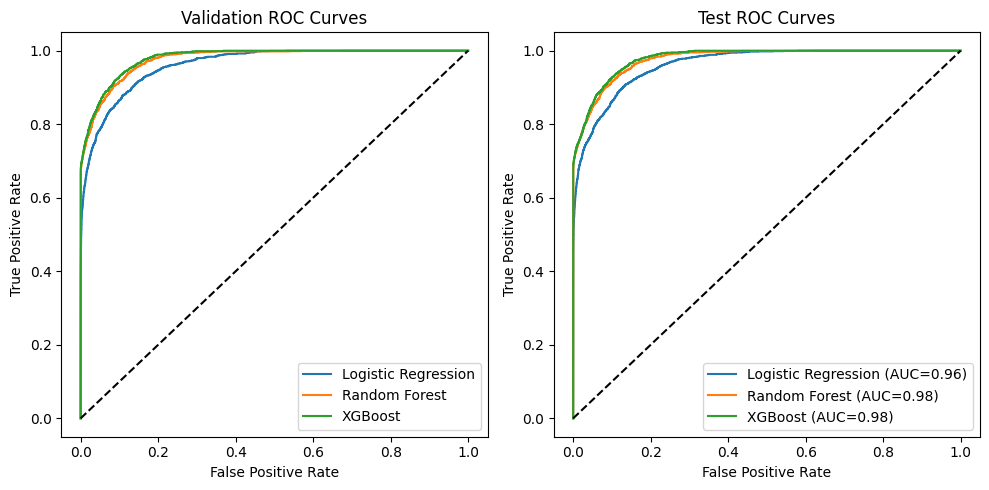

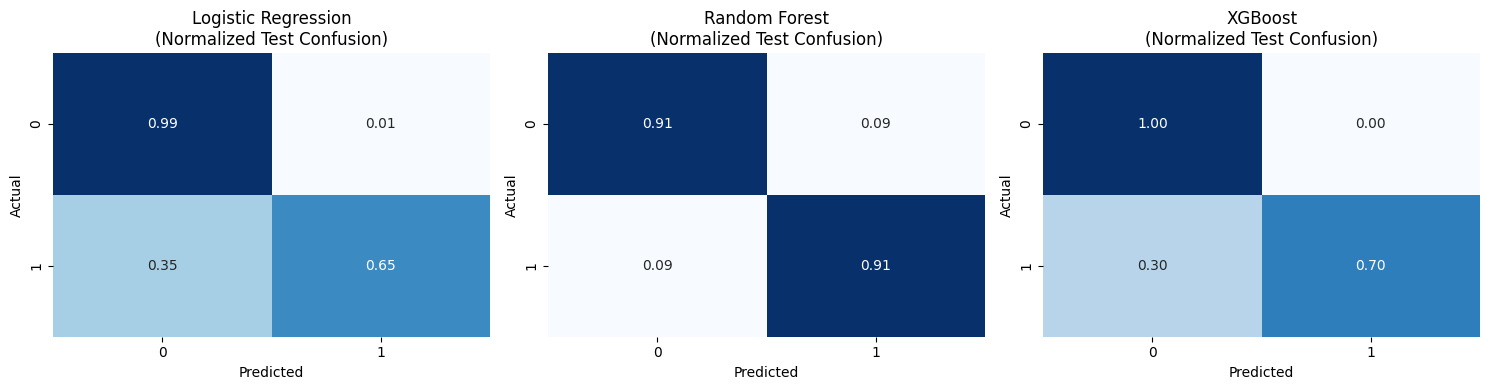

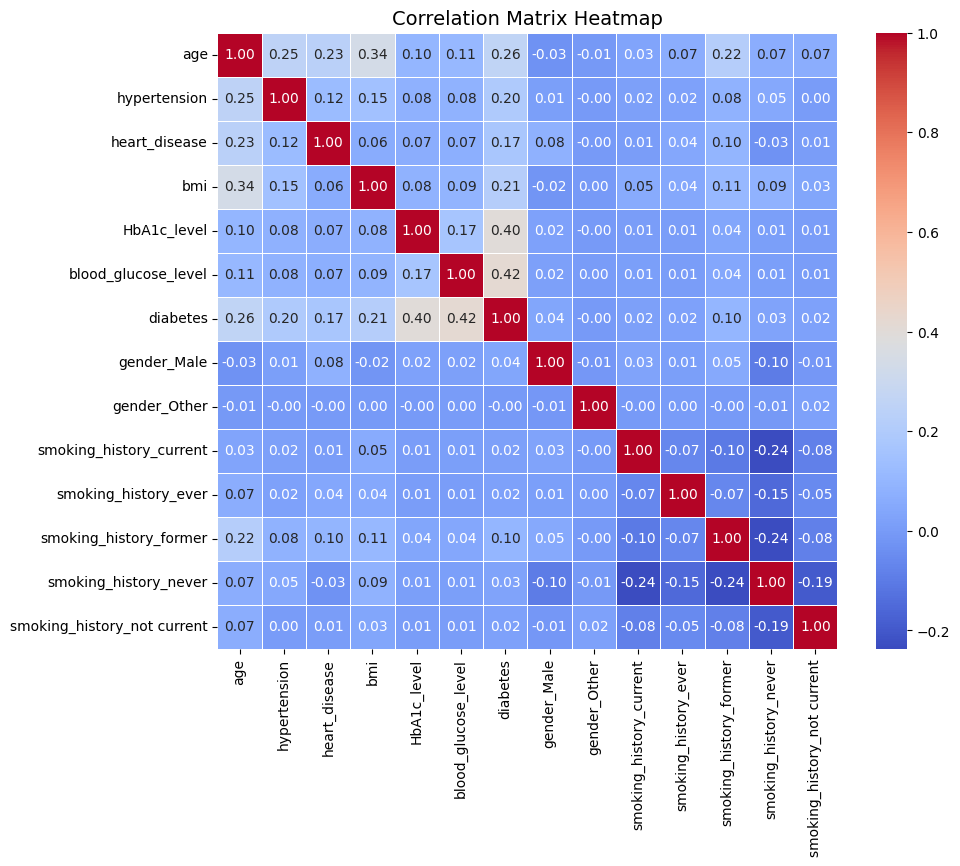

In [1]:
# ============================
# Diabetes Prediction using ML (Train/Validation/Test Split + ROC Curves)
# ============================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 2️⃣ Load Dataset
df = pd.read_csv("https://raw.githubusercontent.com/MonikSense/Diabetes/refs/heads/main/diabetes_prediction_dataset.csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 3️⃣ Detect target column
target_col = "diabetes" if "diabetes" in df.columns else None
if target_col is None:
    raise ValueError("⚠️ Please ensure the dataset has a 'diabetes' column as the target variable.")

print(f"\n✅ Target column detected as: {target_col}")

# 4️⃣ Define Features and Target
X = df.drop(columns=[target_col])
y = df[target_col]

# 5️⃣ Handle Missing Values
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

for col in num_cols:
    X[col] = X[col].fillna(X[col].median())
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# 6️⃣ Encode categorical variables
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# 7️⃣ Split Data → Train / Validation / Test
# First split into train (60%) + temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
# Then split temp into validation (20%) + test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"✅ Data Split: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")

# 8️⃣ Feature Scaling (for LR and XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 9️⃣ Model Definitions
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs', C=1.0),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=42,
        eval_metric='auc'
    )
}

results = {}

# 🔟 Train and Validate Models
for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    # Use scaled data for LR and XGB
    if name == "Random Forest":
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        y_val_prob = model.predict_proba(X_val)[:, 1]
    else:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        y_val_prob = model.predict_proba(X_val_scaled)[:, 1]

    # Validation Metrics
    val_acc = accuracy_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_prob)
    print(f"Validation Accuracy: {val_acc:.3f}, AUC: {val_auc:.3f}")

# 11️⃣ Test Evaluation and ROC Storage
roc_data_val, roc_data_test = {}, {}

for name, model in models.items():
    if name == "Random Forest":
        y_val_prob = model.predict_proba(X_val)[:, 1]
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_val_prob = model.predict_proba(X_val_scaled)[:, 1]
        y_test_pred = model.predict(X_test_scaled)
        y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_prob)
    cm = confusion_matrix(y_test, y_test_pred)
    results[name] = {"accuracy": acc, "auc": auc, "confusion": cm}

    print(f"\n🔹 {name} (Test Set Results)")
    print("Accuracy:", round(acc, 3))
    print("AUC:", round(auc, 3))
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_test_pred))

    # Save ROC data
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    roc_data_val[name] = (fpr_val, tpr_val)
    roc_data_test[name] = (fpr_test, tpr_test)

# 12️⃣ Compare Accuracy (Test Set)
acc_df = pd.DataFrame({m: results[m]["accuracy"] for m in results}, index=["Accuracy"]).T
acc_df.sort_values(by="Accuracy", ascending=False, inplace=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=acc_df.index, y=acc_df['Accuracy'], palette='viridis')
plt.title("Model Accuracy Comparison (Test Set)")
plt.ylim(0, 1)
plt.show()

# 13️⃣ ROC Curves (Validation + Test)
plt.figure(figsize=(10, 5))

# Validation ROC
plt.subplot(1, 2, 1)
for name, (fpr, tpr) in roc_data_val.items():
    plt.plot(fpr, tpr, label=f"{name}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Validation ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# Test ROC
plt.subplot(1, 2, 2)
for name, (fpr, tpr) in roc_data_test.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Test ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()

# 14️⃣ Normalized Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, res) in zip(axes, results.items()):
    cm = res["confusion"]
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f"{name}\n(Normalized Test Confusion)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 15️⃣ Correlation Heatmap
df_encoded = pd.get_dummies(df, drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.show()
